# 5 - Distribution of waiting time below a certain distance

Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$. (In this statistics, if the following event is farther than $R$, skip the $t$ and go to the next pair)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [2]:
# Read data from file and make sure earthquakes are orderd by time

df = pd.read_table("SouthCalifornia-1982-2011_Physics-of-Data.dat",sep=" ")
df = df.sort_values(by = ['time'])

In [3]:
# Set the value of m and select data with magnitude major or equal than m

m = 3
df_m = copy.deepcopy(df[df['magnitude'] >= m])

In [4]:
# Compute the distance and drop the last earthquake

df_m['distance'] = np.sqrt(( df_m['latitude'].diff(periods=-1) )**2+( df_m['longitude'].diff(periods=-1) )**2)
df_m = df_m.dropna()

In [5]:
# Fix the value of the maximum distance r for a fixed m
# Calculate the minimum, maximum and mean distance

print('Maximum distance:',df_m['distance'].max())
print('Minimum distance:',df_m['distance'].min())
print('Mean distance:',df_m['distance'].mean())

r = df_m['distance'].mean()
df_r = copy.deepcopy(df_m[df_m['distance']<r])

Maximum distance: 830750.5840022021
Minimum distance: 10.770329614269007
Mean distance: 125605.58227929876


In [6]:
# Compute the waiting time and and set the first waiting time to 0

df_r['waiting'] = df_r['time'].diff()

df_r.loc[df_r.idxmin(),['waiting']] = 0.

## 5.1 - Histogram with regular binning

In [7]:
df_red = copy.deepcopy(df_r)

In [8]:
# Set the number of bins

nbin = 3000
wbin = (df_red['waiting'].max() - df_red['waiting'].min())/nbin

print("Width of bins: ", wbin)

Width of bins:  1590.3900979200205


/home/michelepuppin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(-10000, 500000)

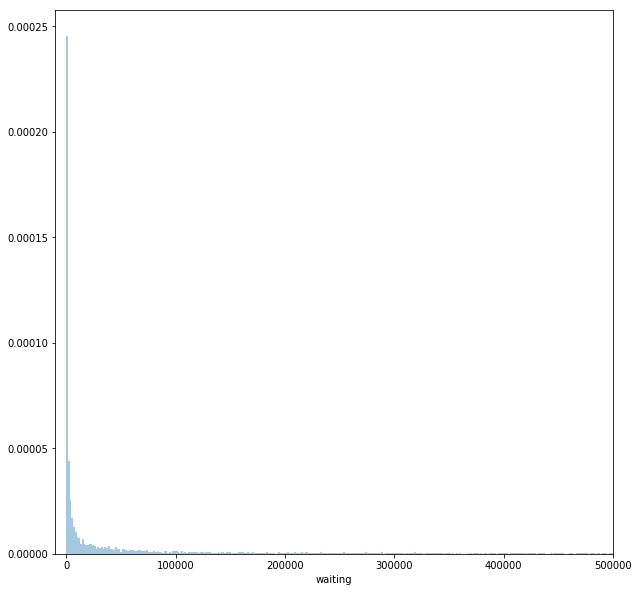

In [9]:
# Plot the histogram with regular bins

fig, ax = plt.subplots(figsize=(10,10))

ax = sns.distplot(df_red['waiting'], bins=nbin, kde=False, norm_hist=True)
ax.set_xlim(-10000,500000)
#ax.set_ylim(0,0.0001)

In [10]:
# Plot the histogram with regular binning in log-log scale

ax = sns.distplot(df_red['waiting'], bins=nbin, kde=False, norm_hist=True)

plt.close()

/home/michelepuppin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [11]:
# Import data from the histogram with regular binning

import matplotlib.patches

width = np.array([h.get_width() for h in ax.patches])
edge = np.array([h.get_xy()[0] for h in ax.patches]) # Right edges
x = np.add(edge,-width/2.) # Center of bins
y = [h.get_height() for h in ax.patches] # Frequency of data 

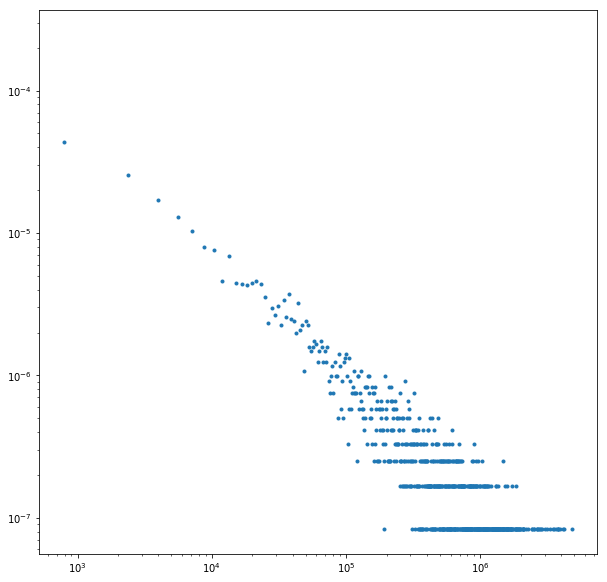

In [12]:
# Dot-visualization of the histogram with regular binning in log-log scale

fig, ax = plt.subplots(figsize=(10,10))

plt.plot(x,y,'.')

plt.xscale('log')
plt.yscale('log')

## 5.2 - Histogram with logarithmic binning

In [13]:
# Set logarithmic binning

width = 1000*np.logspace(0, 3, int(np.sqrt(df_red.shape[0]))+1)

# Compute the right edges

edge = np.cumsum(width)

/home/michelepuppin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(0, 500000)

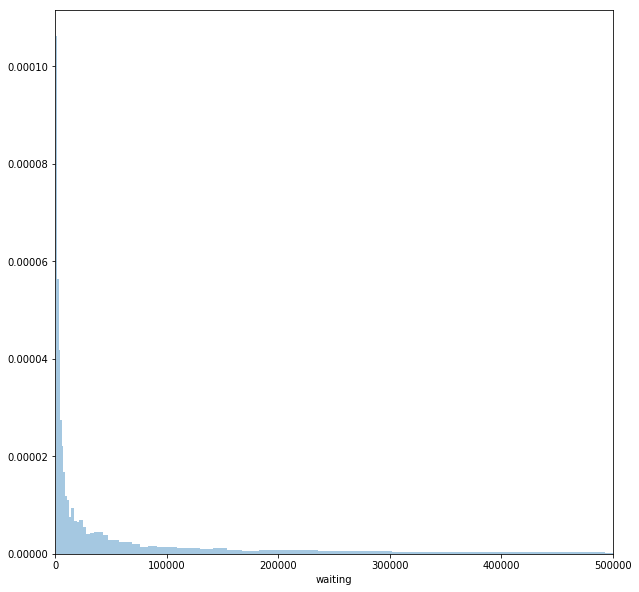

In [14]:
# Histogram with logarithmic binning

fig, ax = plt.subplots(figsize=(10,10))

ax = sns.distplot(df_red['waiting'], bins = edge, kde=False, norm_hist=True)

ax.set_xlim(0,500000)
#ax.set_xscale('log')
#ax.set_yscale('log')

In [15]:
# Import data from the histogram with logarithmic binning

edge = np.array([h.get_xy()[0] for h in ax.patches]) 
width = np.array([h.get_width() for h in ax.patches]) # Right edges
x = np.add(edge, -width/2.) # Center of the bin
y = [h.get_height() for h in ax.patches] # Frequency of data 

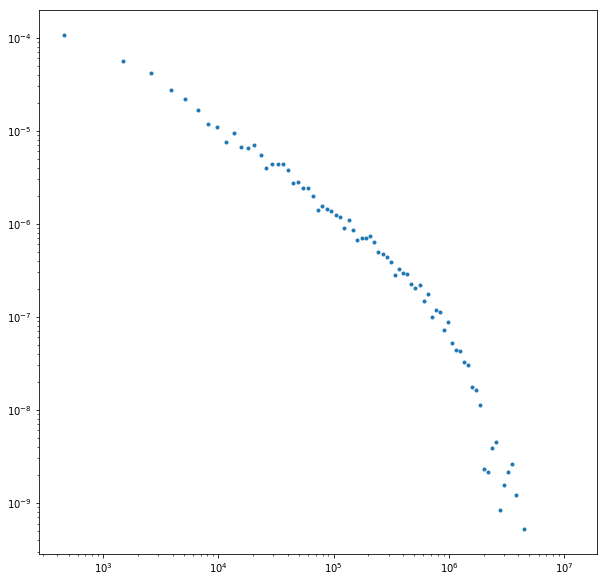

In [16]:
# Dot-visualization of the histogram with logarithmic binning in log-log scale

fig, ax = plt.subplots(figsize=(10,10))

plt.plot(x,y,'.')

plt.xscale('log')
plt.yscale('log')

## 5.3 - Linear regression with tuning of lower cutoff

In [17]:
# Compute vectors with logarithm of frequences and centers of edges in order to perform linear regression

xy = pd.DataFrame({'x':x, 'y':y})

xy = xy[ xy.y != 0 ] # Drop bin with zero frequency in order to compute the logarithm

x =  np.log10(np.array(xy.x))
y = np.log10(np.array(xy.y))

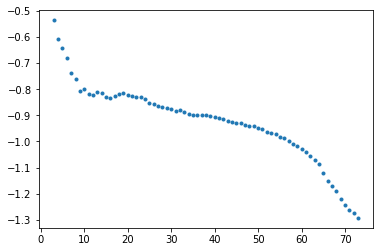

In [18]:
# Perfom linear regression after removing elements from x_m to the end of the vector

from sklearn.linear_model import LinearRegression

alpha = []
x_part = []

for i in range(3,len(x)):
    x_prov = x[:i]
    y_prov = y[:i]
    model = LinearRegression().fit(x_prov.reshape(-1,1), y_prov.reshape(-1,1))
    alpha.append(model.coef_[0][0])
    x_part.append(i)
    
plt.plot(x_part,alpha,'.')

In [19]:
# Choose best x_min

slope = []
chosen_index = []

for i in range(len(x_part)-5):
    x_set = np.array(x_part[i:i+5])
    y_set = np.array(alpha[i:i+5])
    model = LinearRegression().fit(x_set.reshape(-1,1), y_set.reshape(-1,1))
    chosen_index.append(i+5)
    slope.append(model.coef_[0][0])

data_tuples = list(zip(chosen_index,slope))

g = pd.DataFrame(data_tuples,columns=['x_min_index','slope'])
g['slope'] = np.abs(g['slope'])
x_min_index =  np.array(g.loc[g['slope'] == g['slope'].min()])

In [20]:
# Perform linear regression with the best value x_min

x_corr = x[1:int(x_min_index[0][0])]
y_corr = y[1:int(x_min_index[0][0])]

model = LinearRegression().fit(x_corr.reshape(-1,1), y_corr.reshape(-1,1))

print('Intercept:', model.intercept_)
print('Slope:', model.coef_)

Intercept: [-1.48176686]
Slope: [[-0.86631588]]


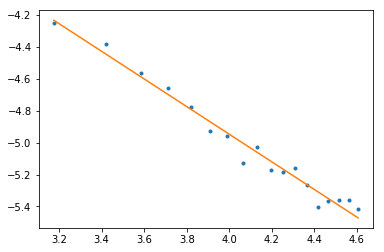

In [21]:
# Plot fit

l = np.linspace(x_corr.min(), x_corr.max(),len(x_corr))

plt.plot(x_corr,y_corr,'.')
plt.plot(l, model.intercept_[0] + model.coef_[0][0]*l)

## 5.5 - Analysis for different values of m and r

/home/michelepuppin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/michelepuppin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/michelepuppin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/michelepuppin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/mi

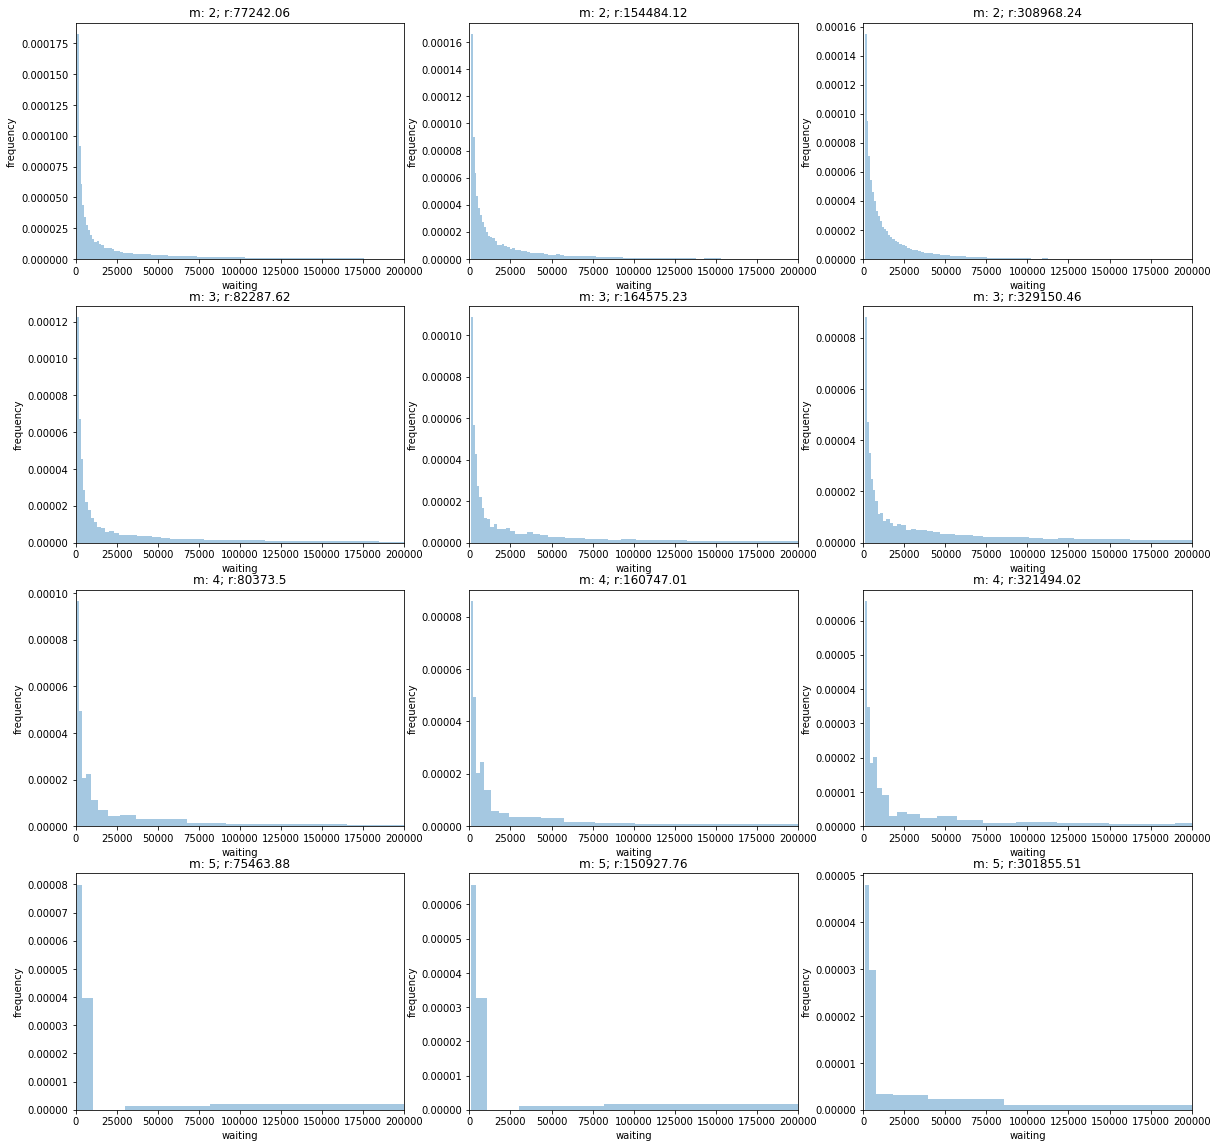

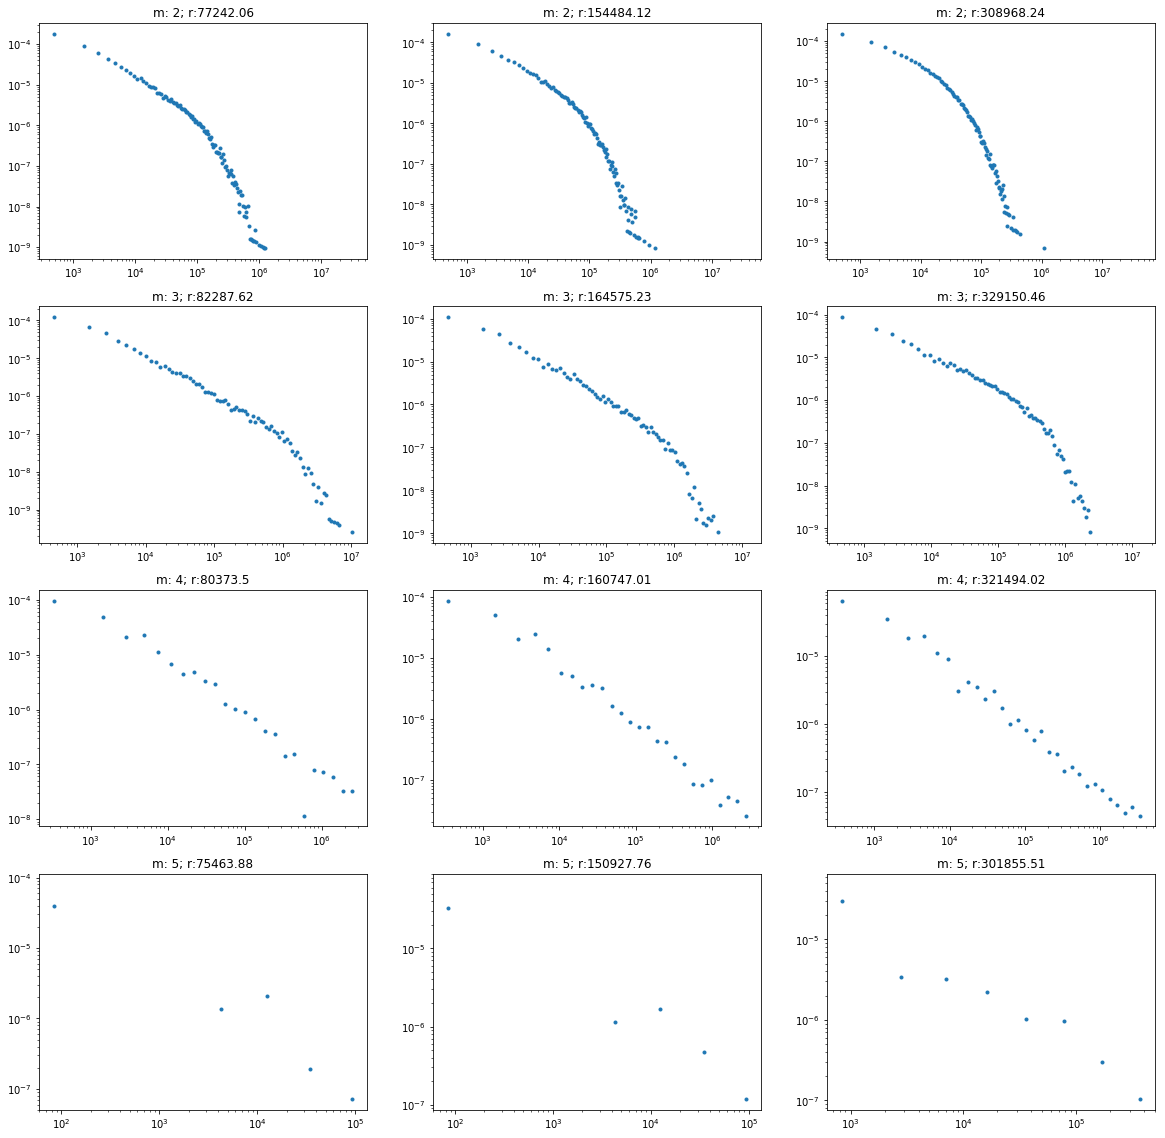

In [22]:
# Reload data
df = pd.read_table("SouthCalifornia-1982-2011_Physics-of-Data.dat",sep=" ")
df = df.sort_values(by = ['time'])

# Set varius the value of m
mag = [2,3,4,5]

# Initialize r
r = [0,0,0]

# Inizialize vectors
xx = np.empty((len(mag),len(r)), object)
yy = np.empty((len(mag),len(r)), object)
mean = np.empty((len(mag),len(r)))
length = np.empty((len(mag),len(r)))

# Create figure 
fig, axes = plt.subplots(nrows=len(mag), ncols=len(r), figsize=(20,20))
fig1, axes1 = plt.subplots(nrows=len(mag), ncols=len(r), figsize=(20,20))
  

for i in range(len(mag)):    
    df_red = copy.deepcopy(df[df['magnitude'] >= mag[i]])
    df_red['distance'] = np.sqrt((df_red['longitude'].diff(periods=-1))**2 + (df_red['latitude'].diff(periods=-1))**2 + (df_red['depth'].diff(periods=-1))**2)     
    df_red = df_red.dropna()  
    r = df_red['distance'].mean()   
    r = [r/2,r,2*r]
    
    for j in range(len(r)):        
        df_r = copy.deepcopy(df_red[df_red['distance']<r[j]])
        df_r['waiting'] = df_r['time'].diff()
        df_r.loc[df_r.idxmin(),['waiting']] = 0.
        
        width = 1000*np.logspace(0, 3, np.sqrt(df_r.shape[0])+1)
        edge = np.cumsum(width)
        
        title = "m: {}; r:{}".format(round(mag[i],2),round(r[j],2))
        
        axes[i,j].set_title(title)    
        axes[i,j].set_xlim(0,200000)
        axes[i,j].set_xlabel('waiting')
        axes[i,j].set_ylabel('frequency')
        
        ax = sns.distplot(df_r['waiting'], bins = edge, kde=False, norm_hist=True, ax=axes[i,j])
        
        edge = np.array([h.get_xy()[0] for h in ax.patches]) 
        width = np.array([h.get_width() for h in ax.patches])
        
        xx[i,j] =  np.array(np.add(edge, -width/2.)) 
        yy[i,j] =  np.array([h.get_height() for h in ax.patches])
        mean[i,j] = df_r['waiting'].mean()
        length[i,j] = df_r['distance'].max()
        
        title = "m: {}; r:{}".format(round(mag[i],2),round(r[j],2))
        
        axes1[i,j].set_title(title)
        axes1[i,j].set_xscale('log')
        axes1[i,j].set_yscale('log')        
        axes1[i,j].plot(xx[i,j],yy[i,j],'.')  

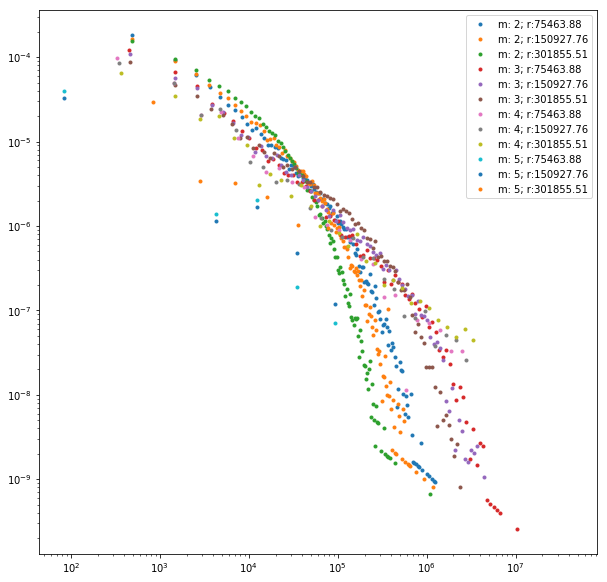

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

ax.set_xscale('log')
ax.set_yscale('log')

for i in range(len(mag)):
    for j in range(len(r)):
        xx[i,j] = xx[i,j]
        yy[i,j] = yy[i,j]
        
        ax.plot(xx[i,j],yy[i,j],'.',label="m: {}; r:{}".format(round(mag[i],2),round(r[j],2)) )

ax.legend()

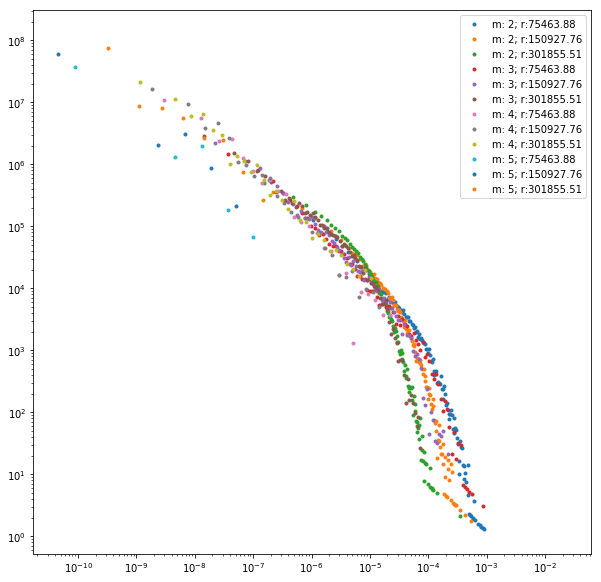

In [24]:
# Plot for all m in log-log scale

fig, ax = plt.subplots(figsize=(10,10))

ax.set_xscale('log')
ax.set_yscale('log')

for i in range(len(mag)):
    for j in range(len(r)):
        xx[i,j] = xx[i,j]/(mean[i,j]*length[i,j])
        yy[i,j] = yy[i,j]*mean[i,j]*length[i,j]
        
        ax.plot(xx[i,j],yy[i,j],'.',label="m: {}; r:{}".format(round(mag[i],2),round(r[j],2)) )

ax.legend()